# Generic Integration With Credo AI's Governance Platform 

Lens is primarily a framework for comprehensive assessment of AI models. However, in addition, it is the primary way to integrate assessment analysis with Credo AI's Governance Platform.

In this tutorial, we will take a model created and assessed _completely independently of Lens_ and send that data to Credo AI's Governance Platform

## Create an example ML Model

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve

### Load data and train model

For the purpose of this demonstration, we will be classifying digits after a large amount of noise has been added to each image.

We'll create some charts and assessment metrics to reflect our work.

In [2]:
# load data
digits = datasets.load_digits()

# add noise
digits.data += np.random.rand(*digits.data.shape)*16

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target)

# create and fit model
clf = SVC(probability=True)
clf.fit(X_train, y_train)

SVC(probability=True)

### Visualize example images along with predicted label

Text(0.5, 0.98, 'Example Images and Predictions')

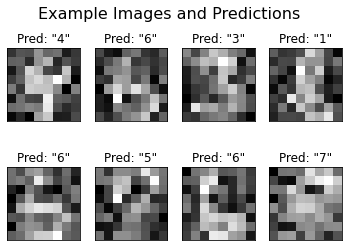

In [3]:
examples_plot = plt.figure()
for i in range(8):
    image_data = X_test[i,:]
    prediction = digits.target_names[clf.predict(image_data[None,:])[0]]
    label = f'Pred: "{prediction}"'
    # plot
    ax = plt.subplot(2,4,i+1)
    ax.imshow(image_data.reshape(8,8), cmap='gray')
    ax.set_title(label)
    ax.tick_params(labelbottom=False, labelleft=False, length=0)
plt.suptitle('Example Images and Predictions', fontsize=16)

### Calculate performance metrics and visualize

As a multiclassification problem, we can calculate metrics per class, or overall. We record overall metrics, but include figures for individual class performance breakdown

In [4]:
metrics = classification_report(y_test, clf.predict(X_test), output_dict=True)
overall_metrics = metrics['macro avg']
del overall_metrics['support']
pprint(overall_metrics)

{'f1-score': 0.8891559887088375,
 'precision': 0.8908219620913833,
 'recall': 0.8915246708059593}


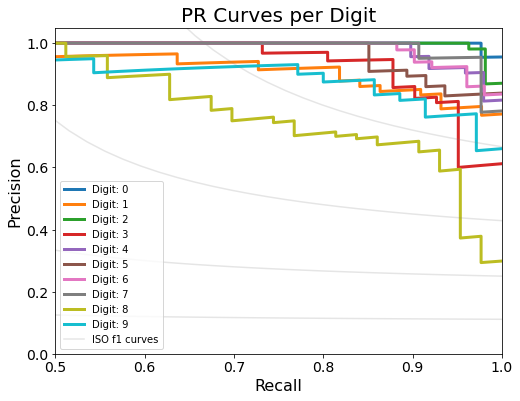

In [5]:
probs = clf.predict_proba(X_test)
pr_curves = plt.figure(figsize=(8,6))
# plot PR curve sper digit
for digit in digits.target_names:
    y_true = y_test == digit
    y_prob = probs[:,digit]
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
    plt.plot(recalls, precisions, lw=3, label=f'Digit: {digit}')
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)

# plot iso lines
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    label = label='ISO f1 curves' if f_score==f_scores[0] else ''
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2, label=label)
# final touches
plt.xlim([0.5, 1.0])
plt.ylim([0.0, 1.05])
plt.tick_params(labelsize=14)
plt.title('PR Curves per Digit', fontsize=20)
plt.legend(loc='lower left', fontsize=10)

/opt/homebrew/Caskroom/miniforge/base/envs/lens/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


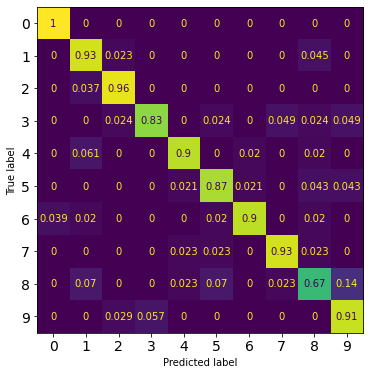

In [6]:
from sklearn.metrics import plot_confusion_matrix
confusion_plot = plt.figure(figsize=(6,6))
plot_confusion_matrix(clf, X_test, y_test, \
                      normalize='true', ax=plt.gca(), colorbar=False)
plt.tick_params(labelsize=14)

## Sending assessment information to Credo AI

Metrics related to performance, fairness, or other governance considerations are the most important kind of evidence needed for governance.

In addition, figures are often produced that help communicate metrics better, understand the model, or other contextualize the AI system. Credo can ingest those as well.

**Which metrics to record?**

Ideally you will have decided on the most important metrics before building the model. We refer to this stage as `Metric Alignment`. This is the phase where your team explicitly determine how you will measure whether your model can be safely deployed. It is part of the more general `Alignment Stage`, which often requires input from multiple stakeholders outside of the team specifically involved in the development of the AI model.

Of course, you may want to record more metrics than those explicitly determined during `Metric Alignment`.

For instance, in this example let's say that during `Metric Alignment`, the _F1 Score_ is the primary metric used to evaluate model performance. However, we have decided that recall and precision would be helpful supporting. So we will send those three metrics.


To reiterate: You are always free to send more metrics - Credo AI will ingest them. It is you and your team's decision which metrics are tracked specifically for governance purposes.

In [7]:
import credoai.integration as ci
from credoai.utils import list_metrics
model_name = 'SVC'
dataset_name = 'sklearn_digits'

## Quick reference

Below is all the code needed to record a set of metrics, figures, inputs and outputs and wrap them all up in a model. We will unpack each part below.

In [8]:
# metrics

metric_records = ci.record_metrics_from_dict(overall_metrics, 
                                             model_label=model_name,
                                             dataset_label=dataset_name)

#figures
example_figure_record = ci.Figure(examples_plot._suptitle.get_text(), examples_plot)
confusion_figure_record = ci.Figure(confusion_plot.axes[0].get_title(), confusion_plot)

pr_curve_caption="""Precision-recall curves are shown for each digit separately.
These are calculated by treating each class as a separate
binary classification problem. The grey lines are 
ISO f1 curves - all points on each curve have identical
f1 scores.
"""
pr_curve_figure_record = ci.Figure(pr_curves.axes[0].get_title(),
                                figure=pr_curves,
                                caption=pr_curve_caption)
figure_records = ci.MultiRecord([example_figure_record, confusion_figure_record, pr_curve_figure_record])

# export to file
# ci.export_to_file(model_record, 'model_record.json')

## Metric Record

To record a metric you can either record each one manually or ingest a dictionary of metrics.

### Manually entering individual metrics

In [9]:
f1_description = """Harmonic mean of precision and recall scores.
Ranges from 0-1, with 1 being perfect performance."""
f1_record = ci.Metric(metric_type='f1', 
                      value=overall_metrics['f1-score'],
                      model_label=model_name, 
                      dataset_label=dataset_name)

precision_record = ci.Metric(metric_type='precision',
                             value=overall_metrics['precision'],
                             model_label=model_name, 
                             dataset_label=dataset_name)

recall_record = ci.Metric(metric_type='recall', 
                          value=overall_metrics['recall'],
                          model_label=model_name, 
                          dataset_label=dataset_name)
metrics = [f1_record, precision_record, recall_record]

### Convenience to record multiple metrics

Multiple metrics can be recorded as long as they are described using a pandas dataframe. 

In [10]:
metric_records = ci.record_metrics_from_dict(overall_metrics, model_name, dataset_name)

## Record figures

Credo can accept a path to an image file or a matplotlib figure. Matplotlib figures are converted to PNG images and saved.


A caption can be included for futher description. Included a caption is recommended when the image is not self-explanatory, which is most of the time! 

In [11]:
example_figure_record = ci.Figure(examples_plot._suptitle.get_text(), examples_plot)
confusion_figure_record = ci.Figure(confusion_plot.axes[0].get_title(), confusion_plot)

pr_curve_caption="""Precision-recall curves are shown for each digit separately.
These are calculated by treating each class as a separate
binary classification problem. The grey lines are 
ISO f1 curves - all points on each curve have identical
f1 scores.
"""
pr_curve_figure_record = ci.Figure(pr_curves.axes[0].get_title(),
                                   figure=pr_curves,
                                   description=pr_curve_caption)
figure_records = [example_figure_record, confusion_figure_record, pr_curve_figure_record]

If many features need to be recorded, the convenience function `create_feature_records` can be used. For instance, the code below records each pixel as a separate input.


In [12]:
input_args = {'name': digits.feature_names,
                'example': digits.data[0]}
inputs_exhaustive = create_input_records(input_args)

NameError: name 'create_input_records' is not defined

In [ ]:
output_description="""Class of the digit corresponding to the highest
probability digit according to the model. 
The probability of each class is also output from the model."""
output_record = Output(name='Digit class',
                example=digits.target_names[3],
                description=output_description)

## Model

To send all the information, we wrap the records in a model record.

In [15]:
metric_records = ci.MultiRecord(metric_records)
figure_records = ci.MultiRecord(figure_records)

## Export to Credo AI

The json object of the model record can be created by calling `MultiRecord.jsonify()`. The convenience function `export_to_file` can be called to export the json record to a file. This file can then be uploaded to Credo AI's Governance Platform.

In [16]:
# filename is the location to save the json object of the model record
# filename="XXX.json"
# ci.export_to_file(model_record, filename)

MultiRecords can be directly uploaded to Credo AI's Governance Platform as well. A model (or data) ID must be known to do so. You use `export_to_credo` to accomplish this.

In [17]:
# model_id = "XXX"
# ci.export_to_credo(model_record, model_id)